# Spis treści
1. [Czym są osadzenia grafów?](#Czym-są-osadzenia-grafów?)
2. [Czym jest Cleora?](#Czym-jest-Cleora?)
3. [Jak działa algorytm?](#Jak-działa-algorytm?)


# Czym są osadzenia grafów?
Wyobraź sobie sieć połączonych ze sobą węzłów, jak na przykład sieć społecznościowa.

<img src="note-imgs/graph.png" width="440" height="330" />

Grafy w tej postaci są trudne do analizy, ponieważ większość algorytmów uczenia maszynowego wymaga wektorów jako wejścia, a nie grafów.
Z pomocą przychodzą nam osadzenia grafów (ang. graph embeddings). 
Dzięki tym osadzeniom jesteśmy w stanie reprezentować wierzchołki jako wektory i dzięki temu jesteśmy w stanie zastosować techniki uczenia maszynowego do analizy i wydobycia znaczących wniosków z tych danych.

<img src="note-imgs/graph-embeddings.png" width="660" height="330" />

Aktualnie mamy kilka sposobów otrzymania osadzeń grafów np.:
- Node2Vec
- DeepWalk
- Cleora, którą się dzisiaj zajmiemy.

# Czym jest Cleora?
Cleora to algorytm stworzony, w celu tworzenia osadzeń grafów w sposób efektywny. 
Dzięki niemu w łatwy i szybki sposób możemy osiągnąć dobrej jakości osadzenia grafów, które pozwalają nam odkryć cenne informacje ukryte w naszych grafach.

Cleora jest algorytmem nienadzorowanym, więc nie potrzebuje etykiet do nauki, a to w łatwy sposób umożliwia mu na tworzenie osadzeń dowolnego grafu.


# Jak działa algorytm?

## 1. Generowanie datasetu

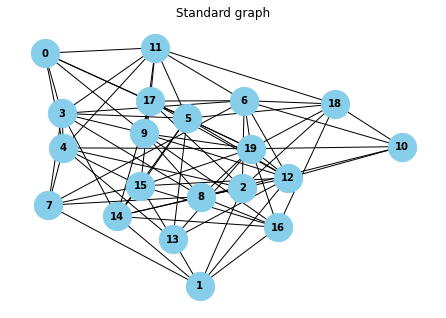

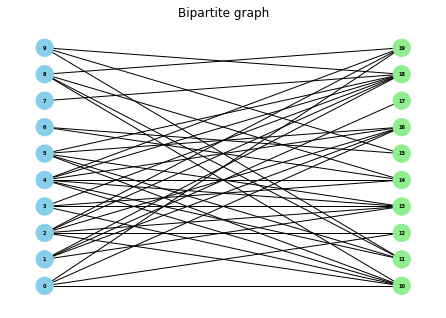

In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def generate_graph(num_n, num_e):
    G = nx.Graph()
    G.add_nodes_from(range(num_n))

    edges = set()
    while len(edges) < num_e:
        node1 = torch.randint(0, num_n, (1,))
        node2 = torch.randint(0, num_n, (1,))
        edge1, edge2 = (node1.item(), node2.item()), (node2.item(), node1.item())
        
        if node1 != node2 and edge1 not in edges and edge2 not in edges:
            edges.add(edge1)
    G.add_edges_from(edges)
    return G

def generate_bipartite_graph(num_n1, num_n2, num_e):
    G = nx.Graph()

    G.add_nodes_from(range(num_n1), bipartite=0)
    G.add_nodes_from(range(num_n1, num_n1 + num_n2), bipartite=1)

    edges = set()
    while len(edges) < num_e:
        node1 = torch.randint(0, num_n1, (1,))
        node2 = torch.randint(num_n1, num_n1 + num_n2, (1,))
        edge1, edge2 = (node1.item(), node2.item()), (node2.item(), node1.item())
        
        if node1 != node2 and edge1 not in edges:
            edges.add(edge1)
    G.add_edges_from(edges)
    return G

num_nodes = 20
num_edges = 80
graph = generate_graph(num_nodes, num_edges)

num_nodes2 = 10
num_edges2 = 40
bipartite_graph = generate_bipartite_graph(num_nodes2, num_nodes2, num_edges2)

nx.draw(graph, with_labels=True, node_color='skyblue', node_size=800, font_size=10, font_weight='bold')
plt.title('Standard graph')
plt.show()

pos = nx.bipartite_layout(bipartite_graph, range(num_nodes2))
nx.draw(bipartite_graph, pos, with_labels=True, node_color=['skyblue']*num_nodes2 + ['lightgreen']*num_nodes2, node_size=300, font_size=5, font_weight='bold')
plt.title('Bipartite graph')
plt.show()

## 2. Cleora (TODO: do sprawdzenia)
1. Inicjalizujemy macierz osadzeń wartościami losowymi z zakresu [-1, 1].
2. Tworzymy macierz spacerów Mq, która mówi nam jakie jest prawdopodobieństwo przejścia z wierzchołka a do wierzchołka b.
3. Mnożymy macierz osadzeń przez macierz spacerów Mq, żeby wykonać nowy krok w spacerze losowym.
4. Normalizujemy macierz osadzeń w celu uniknięcia zbyt dużych wartości w osadzeniach.
5. Powtarzamy kroki 3-4 tyle razy, ile kroków chcemy wykonać w spacerze.

In [2]:
import numpy as np


def create_Mq(adj_mat):
    V = adj_mat.shape[0]
    M = np.zeros((V, V))

    for a in range(V):
        deg_a = np.sum(adj_mat[a])
        if deg_a == 0:
            continue
        
        for b in range(V):
            e_ab = adj_mat[a][b]
            M[a][b] = e_ab / deg_a

    return M


class Cleora:
    def __init__(self, n_nodes, emb_dim):
        self.num_nodes = n_nodes
        self.embedding_dim = emb_dim
        self.embedding_matrix = np.random.rand(n_nodes, emb_dim)

    def embed_graph(self, adj_mat, num_iterations=100):
        Mq = create_Mq(adj_mat)
        
        for _ in range(num_iterations):
            self.embedding_matrix = np.dot(Mq, self.embedding_matrix)
            norm = np.linalg.norm(self.embedding_matrix, axis=1, keepdims=True)
            self.embedding_matrix /= norm + 1e-6

    def get_embedding(self):
        return self.embedding_matrix


## 3. Przykładowe użycie (wygenerowanie osadzeń dla grafu standardowego i dwudzielnego)

In [3]:
embedding_dim = 10
adjacency_matrix = nx.to_numpy_array(graph)
adjacency_matrix_bipartite = nx.to_numpy_array(bipartite_graph)

cleora = Cleora(num_nodes, embedding_dim)
cleora.embed_graph(adjacency_matrix, 5)
embedding = cleora.get_embedding()

cleora_bipartite = Cleora(num_nodes2*2, embedding_dim)
cleora_bipartite.embed_graph(adjacency_matrix_bipartite, 3)
embedding_bipartite = cleora_bipartite.get_embedding()

embedding.shape, embedding_bipartite.shape

((20, 10), (20, 10))

## 4. Wizualizacja dokładności osadzeń poprzez cosine similarity matrix

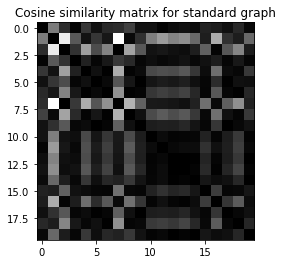

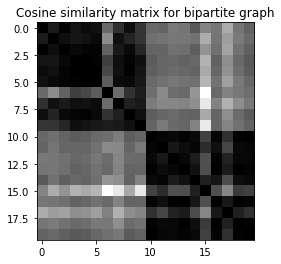

In [4]:
def cosine_similarity_matrix(matrix):
    dot_product = np.dot(matrix, matrix.T)
    norm = np.linalg.norm(matrix, axis=1)
    norm_matrix = np.outer(norm, norm) + 1e-6
    return dot_product / norm_matrix

plt.imshow(cosine_similarity_matrix(embedding), cmap='binary', interpolation='nearest')
plt.title('Cosine similarity matrix for standard graph')
plt.show()

plt.imshow(cosine_similarity_matrix(embedding_bipartite), cmap='binary', interpolation='nearest')
plt.title('Cosine similarity matrix for bipartite graph')
plt.show()

## 5. Sprawdzenie dla dużego grafu

In [5]:
num_nodes = 20_000
num_edges = 80_000
graph = generate_graph(num_nodes, num_edges)

In [6]:
embedding_dim = 100
adjacency_matrix = nx.to_numpy_array(graph, dtype=np.float16)

In [7]:
cleora = Cleora(num_nodes, embedding_dim)
cleora.embed_graph(adjacency_matrix, 5)
embedding = cleora.get_embedding()
embedding.shape

(20000, 100)